In [50]:
using Plots
using Random
using GLPK
using Printf
using JuMP
using LinearAlgebra
using Vec

# Question 1

Let $x_i$, $y_i$ $\text{where } i = \overline{1 .. N}$ be the house sizes and the prices respectively. The decision variables of the problem are $a$, $b$.

The goal is to find $a$ and $b$ that minimise $\sum_{i=1}^{N}{ |y_i - a \cdot x_i - b| }$

To make the cost function linear, we rewrite the problem in terms of artifical variables 

$$u_i \ge |y_i - a \cdot x_i - b| = \max\{y_i - a \cdot x_i - b, -( y_i - a \cdot x_i - b )\} \iff u_i \ge y_i - a \cdot x_i - b \text{ and } u_i \ge -( y_i - a \cdot x_i - b ) $$

As we are minimization, because of the constraints, $u_i$ will approach the absolute value of $|y_i - a \cdot x_i - b|$.

$$ \text{Minimize } \sum_{i=1}^{N}{u_i} $$
$$ \text{with respect to } a, b \text{ and } u_1, ..., u_n$$
$$ \text{subject to } $$
$$ u_i \ge y_i - a \cdot x_i - b \text{ for } i = 1, ..., n$$
$$ u_i \ge -( y_i - a \cdot x_i - b ) \text{ for } i = 1, ..., n $$

In [48]:
dataset = [(200, 300), (280, 320), (120, 260), (205, 395), (595, 495), (685, 540), (625, 580), (810, 610), (975, 700), (895, 545)]
N = length(dataset)
model = Model(GLPK.Optimizer)
@variable(model, a)
@variable(model, b)
@variable(model, u[1:N])
@objective(model, Min, sum(u[1:N]))

for i in 1:N
    x, y = dataset[i]
    @constraint(model, u[i] >= y - a * x - b)
    @constraint(model, u[i] >= -(y - a* x - b))
end

optimize!(model)

A = value(a)
B = value(b)
f(x) = A * x + B
@printf "y = %dx + %d\n" A B

y = 1x + 198


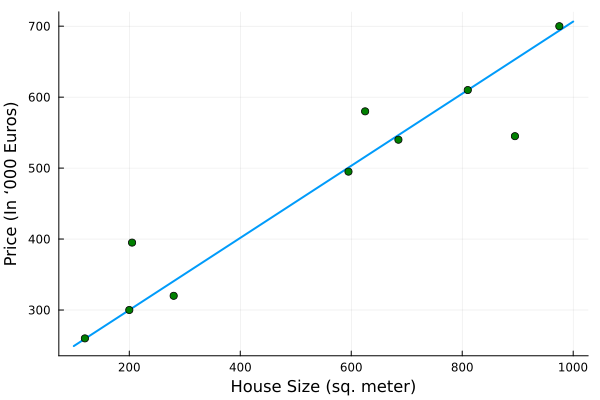

In [49]:
x1 = 100:1000
y1 = [f(x) for x in x1]
p = plot(x1, y1, l2 = 3, label = "", linestyle = :solid, linewidth = 2)
scatter!(p, [x for (x, _) in dataset], [y for (_, y) in dataset], color = [:Green for (x, _) in dataset], label="")
xlabel!(p, "House Size (sq. meter)")
ylabel!(p, "Price (In ‘000 Euros)")
display(p)


# Question 2

We implement the four convex optimisation techniques. That is Gradient Descent, Momentum, Nesterov Momentum and Adam.

In [ ]:
abstract type DescentMethod end

struct GradientDescent <: DescentMethod
    learning_rate # learning rate
end

mutable struct Momentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end

mutable struct NesterovMomentum <: DescentMethod
    learning_rate # learning rate
    momentum_decay # momentum decay
    momentum # momentum
end

mutable struct Adam <: DescentMethod
    learning_rate # learning rate
    decay_v # decay_v
    decay_s # decay_s
    epsilon # small value
    counter # step counter
    v # 1st moment estimate
    s # 2nd moment estimate
end

function run_descent_method(descent_method, initial_point, steps, f, df)
    
    current_point = initial_point
    pointsX = [initial_point[1]]
    pointsY = [initial_point[2]]
    
    for i in 1 : steps
        current_step = step!(descent_method, df, current_point)
        push!(pointsX, current_step[1])
        push!(pointsY, current_step[2])
        current_point = current_step
    end
    return pointsX, pointsY
end

function step!(self::GradientDescent, df, current_point)
    gradient = df(current_point...)
    return current_point - self.learning_rate * gradient
end

function step!(self::Momentum, df, current_point)
    gradient = df(current_point...)
    new_momentum = self.momentum_decay * self.momentum - self.learning_rate * gradient
    self.momentum = new_momentum
    new_point = current_point + new_momentum
    return new_point
end

function step!(self::NesterovMomentum, df, current_point)
    projected_point = current_point + self.momentum_decay * self.momentum
    gradient = df(projected_point...)
    new_momentum = self.momentum_decay * self.momentum - self.learning_rate * gradient
    new_point = current_point + new_momentum
    self.momentum = new_momentum
    return new_point
end

function step!(self::Adam, df, current_point)
    gradient = df(current_point...)
    new_v = self.decay_v * self.v + (1 - self.decay_v) * gradient
    new_s = self.decay_s * self.s + (1 - self.decay_s) * (gradient .* gradient)

    v_hat = new_v / (1 - self.decay_v)
    s_hat = new_s / (1 - self.decay_s)

    self.v = new_v
    self.s = new_s
    self.counter += 1

    return current_point - self.learning_rate * v_hat ./ (self.epsilon .+ sqrt.(s_hat))
end

function plot_contour(
    descent_methods,
    x_domain,
    y_domain,
    f,
    d,
)
    z_fill = @. f(x_domain', y_domain)
    plots = contour(
        x_domain, y_domain, z_fill, 
        cbar=false, color=:turbo, lw=1,
        xlims=(minimum(x_domain), maximum(x_domain)),
        ylims=(minimum(y_domain), maximum(y_domain))
    )

    for (descent_method, name, color, number_of_steps,initial_point) in descent_methods
        pointsX, pointsY = run_descent_method(descent_method, initial_point, number_of_steps, f, df)
        plot!(plots, pointsX, pointsY, seriestype=:line, linecolor=color, label=name, linewidth=2)
    end 

    return plots
end

plot_contour (generic function with 2 methods)

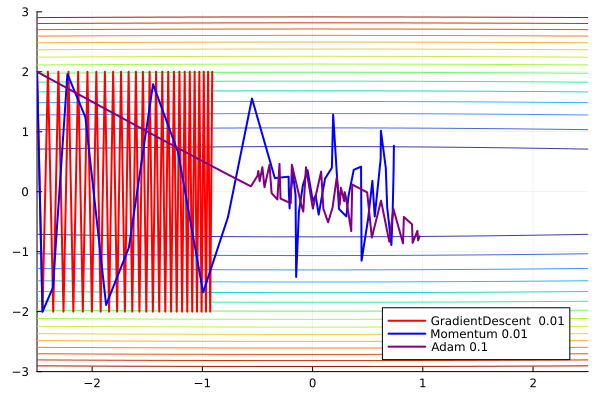

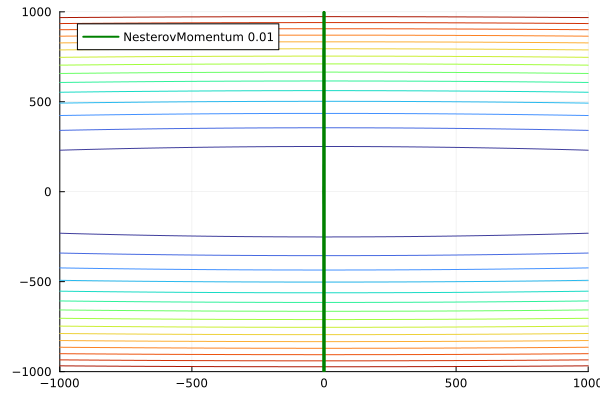

nothing

nothing

In [ ]:
f(x, y) = 0.1 * x * x + 10 * y * y
df(x, y) = [0.2x, 20y]
g(x, y) = x * x + y * y
dg(x, y) = [2x, 2y]
starting_point = (-2.5, 2)
num_step = 50
step_factor = 0.1
decay = 0.9
eps = 10e-8

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (GradientDescent(step_factor), "GradientDescent  0.01", "red", num_step, starting_point))
push!(descent_methods, (Momentum(step_factor,decay,zeros(2)), "Momentum 0.01", "blue", num_step, starting_point))
push!(descent_methods, (Adam(step_factor, decay, decay, eps, 0, zeros(2), zeros(2)), "Adam 0.1", "purple",num_step,starting_point))
p1 = plot_contour(descent_methods, range(-2.5, 2.5, length=100), range(-3, 3, length=100), f, df)

descent_methods = Tuple{DescentMethod, String, String, Int, VecE2{Float64}}[]
push!(descent_methods, (NesterovMomentum(step_factor,decay,zeros(2)), "NesterovMomentum 0.01", "green", num_step, starting_point))
p2 = plot_contour(descent_methods, range(-1000, 1000, length=100), range(-1000, 1000, length=100), f, df)

display(p1)
display(p2)

# Question 3

In [16]:
sigmoid(x) = 1.0 ./ (1.0 .+ exp.(-x))
sigmoid_derivative(x) = sigmoid(x) .* (1 .- sigmoid(x))

sigmoid_derivative (generic function with 1 method)

In [ ]:
mutable struct NeuralNetwork
    inputSize::Int
    hiddenSize::Int
    outputSize::Int

    weightsLayerOne::Matrix{Float64}
    weightsLayerTwo::Matrix{Float64}

    learningRate::Float64
    optimiser::Symbol

    function NeuralNetwork(inputSize::Int, hiddenSize::Int, outputSize::Int; 
                          learningRate::Float64=0.1,
                          optimiser::Symbol=:gd)

        weightsLayerOne = randn(hiddenSize, inputSize) 
        weightsLayerTwo = randn(outputSize, hiddenSize) 

        new(inputSize, hiddenSize, outputSize, 
            weightsLayerOne, weightsLayerTwo,
            learningRate, optimiser)
    end
end

In [4]:
function forward(self::NeuralNetwork, X::Matrix{Float64})

    outputLayerOne = (self.weightsLayerOne * X)
    activationLayerOne = sigmoid(outputLayerOne)

    outputLayerTwo = (self.weightsLayerTwo * activationLayerOne) 
    activationLayerTwo = sigmoid(outputLayerTwo)
    
    return outputLayerOne, activationLayerOne, outputLayerTwo, activationLayerTwo
end

forward (generic function with 1 method)

In [5]:
function predict(self::NeuralNetwork, X::Matrix{Float64})
    _, _, _, activationLayerTwo = forward(self, X)
    return activationLayerTwo
end

predict (generic function with 1 method)

In [6]:
# MSE loss
function calculate_loss(self::NeuralNetwork, X::Matrix{Float64}, y::Matrix{Float64})
    y_pred = predict(self, X)
    return #Implement MSE loss function here
end

calculate_loss (generic function with 1 method)

In [ ]:
function train!(self::NeuralNetwork, X::Matrix{Float64}, y::Matrix{Float64}, epochs::Int=15000)
    losses = []
    
    for epoch in 1:epochs
        
        # Forward pass
        outputLayerOne, activationLayerOne, outputLayerTwo, activationLayerTwo = forward(self, X)
        
        # Calculate loss
        loss = calculate_loss(self, X, y)
        push!(losses, loss)
        
        # Implement backward pass based on partial derivative
        

        # Implement gradient descent, momentum, Adagrad and Adam
        if self.optimiser == :gd
            # Implement gradient descent here
        elseif self.optimiser == :momentum
            # Implement momentum here
        elseif self.optimiser == :adagrad
            # Implement adagrad here
        elseif self.optimiser == :adam
            # Implement Adam here
        end
            
        if epoch % 1000 == 0
            println("Epoch $epoch, Loss: $loss")
        end
    end
    
    return losses
end

# XOR function input and output
X = [[0.0,0.0]  [0.0,1.0]  [1.0,0.0] [1.0, 1.0]]
y = [0.0 1.0 1.0 0.0]

nn = NeuralNetwork(2, 5, 1, learningRate=0.1, optimiser=:gd)
#nn = NeuralNetwork(2, 5, 1, learningRate=0.1, optimiser=:momentum)
#nn = NeuralNetwork(2, 5, 1, learningRate=0.1, optimiser=:adagrad)
#nn = NeuralNetwork(2, 5, 1, learningRate=0.1, optimiser=:adam)

# Test the untrained model
println("\nResults before training:")
for i in 1:size(X, 2)
    input = X[:, i:i] 
    prediction = predict(nn, input)
    println("Input: [$(X[1,i]), $(X[2,i])], Predicted: $(round(prediction[1], digits=5)), Expected: $(y[i])")
end

# Train the neural network and plot the loss
losses = train!(nn, X, y, 15000)
p = plot(1:length(losses), losses, 
         xlabel="Epoch", 
         ylabel="Loss (MSE)", 
         title="Neural Network Training Loss for XOR", 
         legend=false, 
         lw=2,
         yscale=:log10)
display(p)

# Test the trained model
println("\nResults after training:")
for i in 1:size(X, 2)
    input = X[:, i:i]
    prediction = predict(nn, input)
    println("Input: [$(X[1,i]), $(X[2,i])], Predicted: $(round(prediction[1], digits=5)), Expected: $(y[i])")
end